In [1]:
import csv
import os

In [2]:
def calc_sensitivity(tp, fn):
    if tp + fn == 0:
        return 1
    return tp / (tp + fn)

def calc_specificity(tn, fp):
    if tn + fp == 0:
        return 0
    return tn / (tn + fp)

def calc_accuracy(tp, tn, fp, fn):
    if tp + tn + fp + fn == 0:
        return 0
    return (tp + tn) / (tp + tn + fp + fn)

def calc_precision(tp, fp):
    if tp + fp <= 10:
        return 0
    return tp / (tp + fp)

def calc_f1_score(sensitivity, precision):
    if sensitivity + precision == 0:
        return 0
    return 2 * (sensitivity * precision) / (sensitivity + precision)

In [3]:
with open("results.csv", "r") as f:
    reader = csv.reader(f)
    first_row = True
    elements_idcs = {}
    results = {}
    for row in reader:
        if first_row:
            first_row = False
            descriptor_row = row
            for i in range(len(descriptor_row)):
                elements_idcs.update({descriptor_row[i]: i})
            continue
        tp = int(row[elements_idcs["tp"]])
        fp = int(row[elements_idcs["fp"]])
        fn = int(row[elements_idcs["fn"]])
        sensitivity = calc_sensitivity(tp, fn)
        precision = calc_precision(tp, fp)
        accuracy = calc_accuracy(tp, 0, fp, fn)
        f1 = calc_f1_score(sensitivity, precision)
        results.update({
            (row[0], row[1], row[2], row[3]): {
                "tp": tp,
                "fp": fp,
                "fn": fn,
                "sensitivity": sensitivity,
                "precision": precision,
                "f1": f1,
                "accuracy": accuracy,
            }
        })


In [4]:
# For each virus, graph its sensitivity as a function of error tolerance on the same graph
import matplotlib.pyplot as plt
import numpy as np

virus_to_color = {
    "sars-cov-2": "red",
    "influenza": "blue",
    "rotavirus": "green",
    "measles": "orange",
    "lassa": "purple",
}
virus_to_offset = {
    "sars-cov-2": 0.0001,
    "influenza": 0.0002,
    "rotavirus": 0,
    "measles": -0.0001,
    "lassa": -0.0002,
}

virus_to_marker = {
    "sars-cov-2": "o",  # Circle
    "influenza": "s",  # Square
    "rotavirus": "^",  # Triangle up
    "measles": "D",    # Diamond
    "lassa": "x",     # X
}


In [5]:
fontsize = 14

In [6]:
def graph_var_ed(results, sequencer, viruses, fc_exp, result):
    plt.xticks(fontsize=fontsize, fontweight='bold')  # Adjusting font size and weight for x tick labels
    plt.yticks(fontsize=fontsize, fontweight='bold')  # Adjusting font size and weight for y tick labels
    fc = 2 ** fc_exp
    for virus in viruses:
        points = []  # To store (error tolerance, result) pairs for sorting and plotting

        for key in results:
            if (key[elements_idcs["virus"]] == virus and 
                int(key[elements_idcs["faulty cells"]]) == int(fc) and 
                key[elements_idcs["sequencer"]] == sequencer):

                error_tolerance = key[elements_idcs["error tolerance"]]
                result_value = results[key][result]
                points.append((error_tolerance, result_value))

        # Sort points by error tolerance
        points.sort(key=lambda p: p[0])

        # Unpack for plotting
        x_values, y_values = zip(*points)

        # Add dashed line plot with specified marker, line width, and color
        plt.plot(x_values, y_values, linestyle='--', color=virus_to_color[virus], label=virus, 
                 lw=4.0, ms = 10, marker=virus_to_marker[virus])

        # show y axis from zero to 1.19
        plt.ylim(0, 1.19)
        # add label for the virus
        plt.xlabel("Edit distance", fontsize=fontsize, fontweight='bold')
        plt.ylabel(result, fontsize=fontsize, fontweight='bold')
        plt.xticks(fontsize=fontsize, fontweight='bold')  # Adjusting font size and weight for x tick labels
        plt.yticks(fontsize=fontsize, fontweight='bold')  # Adjusting font size and weight for y tick labels

    # Add grid lines
    plt.grid(True, which='both', linestyle='--', linewidth=1, color='gray')

    # Add legend after all lines are added
    # plt.legend(loc="best")  # Use loc="best" to place the legend at the best position
    plt.legend(loc="best", fontsize=12, fontweight='bold')
    plt.title(f"{result} vs. edit distance fc = 2^{fc_exp-20}", fontsize=fontsize, fontweight='bold')
    ax = plt.gca()  # Get the current axis
    for spine in ax.spines.values():  # Iterate over the four spines (top, bottom, left, right)
        spine.set_linewidth(3)  # Set the spine's line width
    # make results dir
    if not os.path.exists("data/results/ed"):
        os.makedirs("data/results/ed")
    plt.savefig(f"data/results/ed/{sequencer}_{result}_{fc}vs_ed.png")
    #clear the plot
    plt.clf()


In [7]:
def graph_var_fc(results, sequencer, viruses, ed, result):
    for virus in viruses:
        points = []  # To store (error tolerance, result) pairs for sorting and plotting

        for key in results:
            if (key[elements_idcs["virus"]] == virus and 
                int(key[elements_idcs["error tolerance"]]) == int(ed) and 
                key[elements_idcs["sequencer"]] == sequencer):

                fc = int(key[elements_idcs["faulty cells"]])
                result_value = results[key][result]
                points.append((fc, result_value))

        # Sort points by error tolerance
        points.sort(key=lambda p: p[0])

        # Unpack for plotting
        x_values, y_values = zip(*points)

        # Add line plot, every line should have a width of 3
        # plt.plot(x_values, y_values, "o-", color=virus_to_color[virus], label=virus, lw=4, ms=10)
        plt.plot(x_values, y_values, linestyle='--', color=virus_to_color[virus], label=virus, 
                 lw=4.0, ms=10, marker=virus_to_marker[virus])
    

        # show y axis from zero to 1.19
        plt.ylim(0, 1.19)
        # add label for the virus
        plt.xlabel("faulty cells", fontsize=fontsize, fontweight='bold')
        plt.ylabel(result, fontsize=fontsize, fontweight='bold')
        plt.xticks(fontsize=fontsize, fontweight='bold')  # Adjusting font size and weight for x tick labels
        plt.yticks(fontsize=fontsize, fontweight='bold')  # Adjusting font size and weight for y tick labels

    plt.grid(True, which='both', linestyle='--', linewidth=1, color='gray')

    # Add legend after all lines are added
    plt.legend(loc="best", fontsize=12, fontweight='bold')
    plt.title(f"{sequencer}: {result} vs. edit distance ed = {ed}", fontsize=fontsize, fontweight='bold')
    ax = plt.gca()  # Get the current axis
    for spine in ax.spines.values():  # Iterate over the four spines (top, bottom, left, right)
        spine.set_linewidth(3)  # Set the spine's line width
    if not os.path.exists("data/results/fc"):
        os.makedirs("data/results/fc")
    plt.figure(figsize=(12, 5))
    plt.savefig(f"data/results/fc/{sequencer}_{result}_{ed}vs_fc.png", dpi=10000)
    #clear the plot
    plt.clf()


TypeError: Legend.__init__() got an unexpected keyword argument 'fontweight'

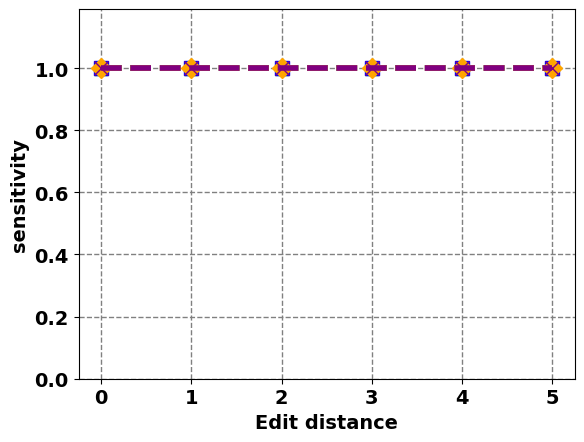

In [8]:
graph_var_ed(results, "illumina", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 14, "sensitivity")
graph_var_ed(results, "illumina", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 14, "precision")
graph_var_ed(results, "illumina", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 14, "f1")

graph_var_ed(results, "roche", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 14, "sensitivity")
graph_var_ed(results, "roche", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 14, "precision")
graph_var_ed(results, "roche", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 14, "f1")

graph_var_ed(results, "pacbio", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 14, "sensitivity")
graph_var_ed(results, "pacbio", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 14, "precision")
graph_var_ed(results, "pacbio", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 14, "f1")

In [ ]:
graph_var_fc(results, "illumina", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 1, "sensitivity")
graph_var_fc(results, "illumina", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 1, "precision")
graph_var_fc(results, "illumina", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 1, "f1")

graph_var_fc(results, "roche", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 1, "sensitivity")
graph_var_fc(results, "roche", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 1, "precision")
graph_var_fc(results, "roche", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 1, "f1")

graph_var_fc(results, "pacbio", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 1, "sensitivity")
graph_var_fc(results, "pacbio", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 1, "precision")
graph_var_fc(results, "pacbio", ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"], 1, "f1")

In [4]:
def write_var_ed_results(results, viruses, sequencer, fc, result, csv_writer):
    csv_writer.writerow([sequencer, result])
    csv_writer.writerow(["", "Virus"])
    csv_writer.writerow(["ED"] + viruses)
    for ed in [0,1,2,3,4,5]:
        csv_writer.writerow([ed] + [results[(virus, sequencer, str(ed), str(fc))][result] for virus in viruses])


def write_var_fc_results(results, viruses, sequencer, ed, result, csv_writer):
    csv_writer.writerow([sequencer, result])
    csv_writer.writerow(["", "Virus"])
    csv_writer.writerow(["FC"] + viruses)
    for fc_exp in [12,13,14,15,16,17,18]:
        fc = 2 ** fc_exp
        csv_writer.writerow([f"2^{fc_exp-20}"] + [results[(virus, sequencer, str(ed), str(fc))][result] for virus in viruses])


def write_avg_var_ed_results(results, viruses, sequencer, fcs, result, csv_writer):
    csv_writer.writerow([sequencer, result])
    csv_writer.writerow(["ED"] + fcs)
    for ed in [0,1,2,3,4,5]:
        csv_writer.writerow([ed] + [np.mean([results[(virus, sequencer, str(ed), str(fc))][result] for virus in viruses]) for fc in fcs])


def write_avg_var_fc_results(results, viruses, sequencer, eds, result, csv_writer):
    csv_writer.writerow([sequencer, result])
    csv_writer.writerow(["FC"] + eds)
    for fc_exp in [12,13,14,15,16,17,18]:
        fc = 2 ** fc_exp
        csv_writer.writerow([f"2^{fc_exp-20}"] + [np.mean([results[(virus, sequencer, str(ed), str(fc))][result] for virus in viruses]) for ed in eds])

        
    

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (1789514694.py, line 15)

In [20]:
viruses = ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"]
fc_exp = 0
if fc_exp == 0:
    fc = 0
else:
    fc = 2 ** fc_exp
with open(f"data/results/fc=2^{fc_exp-20}.csv", "w") as f:
    writer = csv.writer(f)
    write_var_ed_results(results, viruses,"illumina", fc, "sensitivity", writer)
    write_var_ed_results(results, viruses, "illumina", fc, "precision", writer)
    write_var_ed_results(results, viruses, "illumina", fc, "f1", writer)
    write_var_ed_results(results, viruses,"roche", fc, "sensitivity", writer)
    write_var_ed_results(results, viruses, "roche", fc, "precision", writer)
    write_var_ed_results(results, viruses, "roche", fc, "f1", writer)
    write_var_ed_results(results, viruses,"pacbio", fc, "sensitivity", writer)
    write_var_ed_results(results, viruses, "pacbio", fc, "precision", writer)
    write_var_ed_results(results, viruses, "pacbio", fc, "f1", writer)

In [22]:
viruses = ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"]
ed = 3
with open(f"data/results/ed={ed}.csv", "w") as f:
    writer = csv.writer(f)
    write_var_fc_results(results, viruses, "illumina", ed, "sensitivity", writer)
    write_var_fc_results(results, viruses, "illumina", ed, "precision", writer)
    write_var_fc_results(results, viruses, "illumina", ed, "f1", writer)
    write_var_fc_results(results, viruses, "roche", ed, "sensitivity", writer)
    write_var_fc_results(results, viruses, "roche", ed, "precision", writer)
    write_var_fc_results(results, viruses, "roche", ed, "f1", writer)
    write_var_fc_results(results, viruses, "pacbio", ed, "sensitivity", writer)
    write_var_fc_results(results, viruses, "pacbio", ed, "precision", writer)
    write_var_fc_results(results, viruses, "pacbio", ed, "f1", writer)

In [11]:
viruses = ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"]
eds = [0,1,2,3,4,5]
with open(f"data/results/avg_var_fc.csv", "w") as f:
    writer = csv.writer(f)
    write_avg_var_fc_results(results, viruses, "illumina", eds, "sensitivity", writer)
    write_avg_var_fc_results(results, viruses, "illumina", eds, "precision", writer)
    write_avg_var_fc_results(results, viruses, "illumina", eds, "f1", writer)
    write_avg_var_fc_results(results, viruses, "roche", eds, "sensitivity", writer)
    write_avg_var_fc_results(results, viruses, "roche", eds, "precision", writer)
    write_avg_var_fc_results(results, viruses, "roche", eds, "f1", writer)
    write_avg_var_fc_results(results, viruses, "pacbio", eds, "sensitivity", writer)
    write_avg_var_fc_results(results, viruses, "pacbio", eds, "precision", writer)
    write_avg_var_fc_results(results, viruses, "pacbio", eds, "f1", writer)

NameError: name 'np' is not defined

In [26]:
viruses = ["sars-cov-2", "rotavirus", "influenza", "measles", "lassa"]
fcs = [0, 2 ** 12, 2 ** 13, 2 ** 14, 2 ** 15, 2 ** 16, 2 ** 17, 2 ** 18]
with open(f"data/results/avg_var_ed.csv", "w") as f:
    writer = csv.writer(f)
    write_avg_var_ed_results(results, viruses, "illumina", fcs, "sensitivity", writer)
    write_avg_var_ed_results(results, viruses, "illumina", fcs, "precision", writer)
    write_avg_var_ed_results(results, viruses, "illumina", fcs, "f1", writer)
    write_avg_var_ed_results(results, viruses, "roche", fcs, "sensitivity", writer)
    write_avg_var_ed_results(results, viruses, "roche", fcs, "precision", writer)
    write_avg_var_ed_results(results, viruses, "roche", fcs, "f1", writer)
    write_avg_var_ed_results(results, viruses, "pacbio", fcs, "sensitivity", writer)
    write_avg_var_ed_results(results, viruses, "pacbio", fcs, "precision", writer)
    write_avg_var_ed_results(results, viruses, "pacbio", fcs, "f1", writer)

In [15]:
results[('influenza', 'illumina', '1', '0')]

{'tp': 1000,
 'fp': 0,
 'fn': 0,
 'sensitivity': 1.0,
 'precision': 1.0,
 'f1': 1.0,
 'accuracy': 1.0}